In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
from shapely.geometry import Point
from geopandas import GeoDataFrame, read_file
import geopandas as gpd
import random
import os

# Load the data
mod_data = pd.read_csv(
    'spring_sample_points_annual_21april2022_na_filtered.csv')
mod_data = mod_data.dropna()

# Ensure necessary directories exist
# os.makedirs('models/spring', exist_ok=True)
# os.makedirs('predictions/spring', exist_ok=True)
# os.makedirs('importance/spring', exist_ok=True)
# os.makedirs('model_performance/spring', exist_ok=True)

In [12]:

# Adjust land use columns
landuse_columns = [col for col in mod_data.columns if 'landuse' in col]
mod_data[landuse_columns] = mod_data[landuse_columns] * 100

mod_data['ID'] = mod_data.apply(lambda row: f"{row['x']}_{row['y']}", axis=1)
# 数据拆分
print("拆分数据集...")
locations = mod_data['ID'].unique()
random.seed(7)
random.shuffle(locations)
train_locations, valid_locations, holdout_locations = np.split(
    locations, [int(.75*len(locations)), int(.90*len(locations))])
print(f"训练集大小: {len(train_locations)}, 验证集大小: {len(valid_locations)}, 保留集大小: {len(holdout_locations)}")

拆分数据集...
训练集大小: 751883, 验证集大小: 150376, 保留集大小: 100252


In [14]:

# Define columns to include in the model
columns_to_include = [
    "year", "skybright_spring", "ANDD_MAR.1", "ANDD_APR.1", "ANDD_MAR.2", "ANDD_APR.2", "ANDD_MAY.1", "ANDD_MAY.2",
    "ANDD_JUN.1", "ANDD_JUN.2", "light_dist_spring", "MAR_EVI", "APR_EVI", "MAY_EVI", "JUN_EVI", "usa_pd",
    "impervious_1km", "landuse_11_5kmbuff", "landuse_12_5kmbuff", "landuse_21_5kmbuff", "landuse_23_5kmbuff",
    "landuse_24_5kmbuff", "landuse_31_5kmbuff", "landuse_41_5kmbuff", "landuse_42_5kmbuff", "landuse_43_5kmbuff",
    "landuse_52_5kmbuff", "landuse_71_5kmbuff", "landuse_81_5kmbuff", "landuse_82_5kmbuff", "landuse_90_5kmbuff",
    "landuse_95_5kmbuff", "landuse_25m_class_11", "landuse_25m_class_12", "landuse_25m_class_21", "landuse_25m_class_23",
    "landuse_25m_class_24", "landuse_25m_class_31", "landuse_25m_class_41", "landuse_25m_class_42", "landuse_25m_class_43",
    "landuse_25m_class_52", "landuse_25m_class_71", "landuse_25m_class_81", "landuse_25m_class_82", "landuse_25m_class_90",
    "landuse_25m_class_95", "near_neigh_km", "patch_area_km", "precip_spring", "viirs_spring", "elevation", "radar_dist_km",
    "distance_to_coast_1km", "tree_canopy_cover"
]

# Load the shapefile and generate random sample points
usa = gpd.read_file(
    "gadm41_USA_0.shp")
usa = usa.to_crs(
    "+proj=aea +lat_0=23 +lon_0=-96 +lat_1=29.5 +lat_2=45.5 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs")
usa = usa.simplify(tolerance=5000)


In [9]:

# 从GeoJSON文件读取随机样本点
bb_samples_gdf = gpd.read_file("random_sample_points.geojson")
bb_samples = bb_samples_gdf.geometry.tolist()
print("已从 random_sample_points.geojson 读取随机样本点")

已从 random_sample_points.geojson 读取随机样本点


可视化生成的样本点...


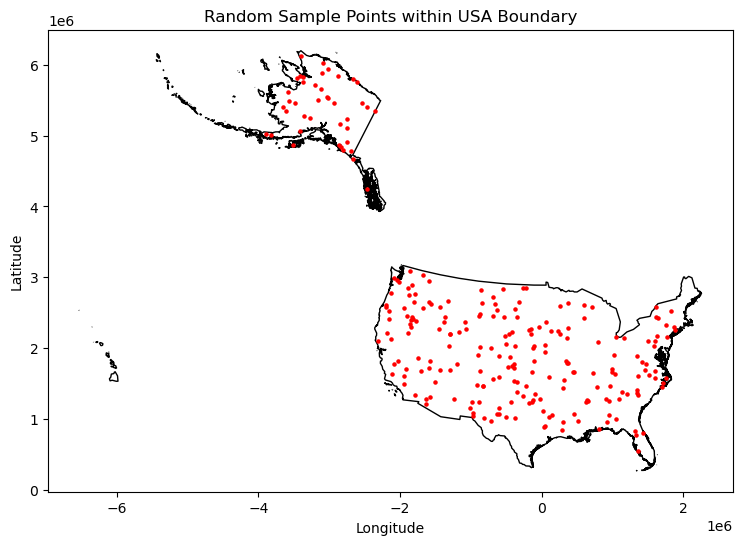

In [15]:
import matplotlib.pyplot as plt
usa_gdf = gpd.GeoDataFrame(geometry=[usa.unary_union])
# 可视化生成的样本点
print("可视化生成的样本点...")
bb_samples_gdf = gpd.GeoDataFrame(geometry=bb_samples)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
base = usa_gdf.plot(ax=ax, color='white', edgecolor='black')
bb_samples_gdf.plot(ax=base, marker='o', color='red', markersize=5)
plt.title("Random Sample Points within USA Boundary")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

可视化生成的样本点...


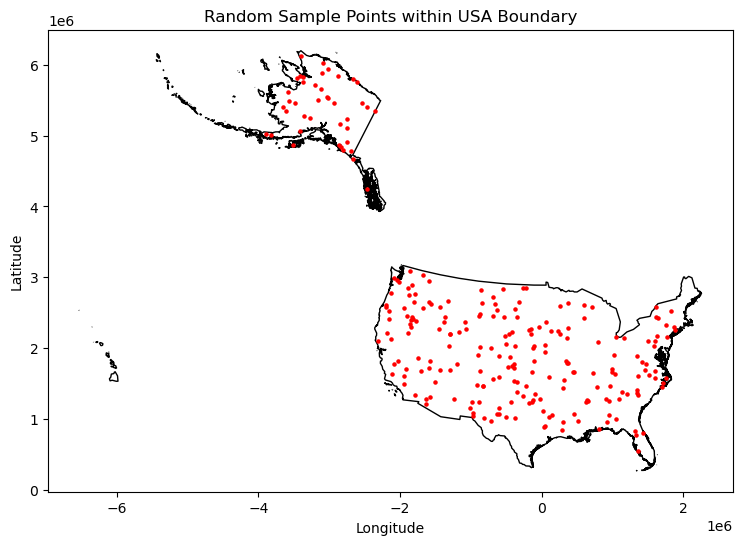

In [8]:
import matplotlib.pyplot as plt
usa_gdf = gpd.GeoDataFrame(geometry=[usa.unary_union])
# 可视化生成的样本点
print("可视化生成的样本点...")
bb_samples_gdf = gpd.GeoDataFrame(geometry=bb_samples)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
base = usa_gdf.plot(ax=ax, color='white', edgecolor='black')
bb_samples_gdf.plot(ax=base, marker='o', color='red', markersize=5)
plt.title("Random Sample Points within USA Boundary")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [8]:

# Iterate through the bounding boxes
bbox_start, bbox_end, bb_size = 1, 250, 200000
param = {
    'max_depth': 10,
    'eta': 0.1,
    'min_child_weight': 1,
    'gamma': 0,
    'colsample_bytree': 1,
    'subsample': 1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

In [23]:
from tqdm import tqdm
for b in tqdm(range(bbox_start, bbox_end + 1)):
    data_for_xgb = mod_data.copy()
    print(f"处理边界框 {b}...")
    bbox = bb_samples_gdf.geometry[b-1].bounds
    data_for_xgb = data_for_xgb[
        (data_for_xgb['x'] < bbox[2] + bb_size) & (data_for_xgb['x'] > bbox[0] - bb_size) &
        (data_for_xgb['y'] > bbox[1] -
         bb_size) & (data_for_xgb['y'] < bbox[3] + bb_size)
    ]

    if data_for_xgb.empty:
        print(f"边界框 {b} 没有数据，跳过...")
        continue

    train_data = data_for_xgb[data_for_xgb['ID'].isin(train_locations)]
    valid_data = data_for_xgb[data_for_xgb['ID'].isin(valid_locations)]
    holdout_data = data_for_xgb[data_for_xgb['ID'].isin(holdout_locations)]
    if train_data.empty or valid_data.empty or holdout_data.empty:
        print(f"边界框 {b} 训练/验证/保留数据集为空，跳过...")
        continue

    dtrain = xgb.DMatrix(
        data=train_data[columns_to_include], label=train_data['spri_stopover'])
    dvalid = xgb.DMatrix(
        data=valid_data[columns_to_include], label=valid_data['spri_stopover'])
    dholdout = xgb.DMatrix(
        data=holdout_data[columns_to_include], label=holdout_data['spri_stopover'])

    watchlist = [(dtrain, 'train'), (dvalid, 'test')]

    print("训练模型...")
    results = []
    model = xgb.train(param, dtrain, num_boost_round=1000,
                  early_stopping_rounds=10, evals=watchlist)

    preds = model.predict(dvalid)
    response = valid_data['spri_stopover']

    results.append({
        'best_iteration': model.best_iteration,
        'best_score': model.best_score,
        'rmse': np.sqrt(mean_squared_error(response, preds)),
        'r2': r2_score(response, preds)
    })

    # Save the model and importance list
    model.save_model(
        f"models/spring/xgb.bst.train_spring_{b}.model")
    importance = model.get_score(importance_type='weight')
    pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance']).to_csv(
        f"importance/spring/importance_spring_{b}.csv", index=False)
    
    # 预测并评估
    print("预测并评估模型...")
    holdout_preds = model.predict(dholdout)
    holdout_data['preds_holdout'] = holdout_preds

    for year in range(2016, 2021):
        holdout_year_data = holdout_data[holdout_data['year'] == year]
        correlation = holdout_year_data[[
            'spri_stopover', 'preds_holdout']].corr().iloc[0, 1]
        results.append({'year': year, 'correlation': correlation})

    pd.DataFrame(results).to_csv(
        f"model_performance/spring/spring_mod_per_{b}.csv", index=False)

  0%|          | 0/250 [00:00<?, ?it/s]

处理边界框 1...
训练模型...
[0]	train-rmse:74.11013	test-rmse:73.71860
[1]	train-rmse:67.28910	test-rmse:66.95339
[2]	train-rmse:61.16087	test-rmse:60.90690
[3]	train-rmse:55.63381	test-rmse:55.43982
[4]	train-rmse:50.74207	test-rmse:50.62283
[5]	train-rmse:46.30771	test-rmse:46.29241
[6]	train-rmse:42.32652	test-rmse:42.40998
[7]	train-rmse:38.78070	test-rmse:38.96399
[8]	train-rmse:35.61753	test-rmse:35.88933
[9]	train-rmse:32.78666	test-rmse:33.15278
[10]	train-rmse:30.28029	test-rmse:30.73098
[11]	train-rmse:27.99301	test-rmse:28.55699
[12]	train-rmse:26.01201	test-rmse:26.67891
[13]	train-rmse:24.24969	test-rmse:25.00136
[14]	train-rmse:22.61988	test-rmse:23.48388
[15]	train-rmse:21.09567	test-rmse:22.07105
[16]	train-rmse:19.81915	test-rmse:20.90936
[17]	train-rmse:18.69137	test-rmse:19.88951
[18]	train-rmse:17.69887	test-rmse:19.00250
[19]	train-rmse:16.71002	test-rmse:18.11564
[20]	train-rmse:15.92568	test-rmse:17.42859
[21]	train-rmse:15.17127	test-rmse:16.78051
[22]	train-rmse:14.5753

  0%|          | 0/250 [00:15<?, ?it/s]


KeyboardInterrupt: 

In [17]:

from tqdm import tqdm
# 假设之前已经完成训练和预测步骤，现在我们只需要保存结果
predictions = []

for b in tqdm(range(bbox_start, bbox_end + 1)):
    data_for_xgb = mod_data.copy()
    # print(f"处理边界框 {b}...")
    # bbox = bb_samples_gdf.geometry[b-1].bounds
    # data_for_xgb = data_for_xgb[
    #     (data_for_xgb['x'] < bbox[2] + bb_size) & (data_for_xgb['x'] > bbox[0] - bb_size) &
    #     (data_for_xgb['y'] > bbox[1] -
    #      bb_size) & (data_for_xgb['y'] < bbox[3] + bb_size)
    # ]

    # if data_for_xgb.empty:
    #     print(f"边界框 {b} 没有数据，跳过...")
    #     continue
    
    # print(f"处理边界框 {b} 的预测结果...")
    # holdout_data = data_for_xgb[data_for_xgb['ID'].isin(holdout_locations)]

    for year in range(2016, 2021):
        predictor_layer = pd.read_csv(
            f"./predict_csvs/predict_{year}_spring_v2.csv")
        bbox = bb_samples_gdf.geometry[b-1].bounds
        predictor_layer = predictor_layer[
            (predictor_layer['x'] < bbox[2] + bb_size) & (predictor_layer['x'] > bbox[0] - bb_size) &
            (predictor_layer['y'] > bbox[1] -
             bb_size) & (predictor_layer['y'] < bbox[3] + bb_size)
        ]

        if predictor_layer.empty:
            print(f"边界框 {b} 的预测年份 {year} 没有数据，跳过...")
            continue

        predictor_layer[landuse_columns] = predictor_layer[landuse_columns] * 100
        predictor_layer['ID'] = predictor_layer.apply(
            lambda row: f"{row['x']}_{row['y']}", axis=1)
        predictor_layer = predictor_layer[predictor_layer['ID'].isin(
            holdout_locations)]
        predictor_data = predictor_layer[columns_to_include]
        # print(predictor_data)
        # print("-"*80)

        # 加载训练好的模型
        model = xgb.Booster()
        model.load_model(
            f"./models/spring/xgb.bst.train_spring_{b}.model")

        map_of_prediction = model.predict(xgb.DMatrix(data=predictor_data))
        # print(map_of_prediction)
        # print("-"*80)
        # print(predictor_layer['spri_stopover'])
        prediction_df = pd.DataFrame({
            'b': b,
            'year': year,
            '真实值': predictor_layer['spri_stopover'],  # 保留数据中的真实值
            '预测值': map_of_prediction
        })

        predictions.append(prediction_df)

# 将所有预测结果合并到一个 CSV 文件中
if predictions:
    all_predictions = pd.concat(predictions, ignore_index=True)
    all_predictions.to_csv(
        f"predictions/spring_predictions.csv", index=False)

  2%|▏         | 4/250 [01:04<1:06:26, 16.21s/it]

边界框 5 的预测年份 2016 没有数据，跳过...
边界框 5 的预测年份 2017 没有数据，跳过...
边界框 5 的预测年份 2018 没有数据，跳过...
边界框 5 的预测年份 2019 没有数据，跳过...


  2%|▏         | 5/250 [01:21<1:06:14, 16.22s/it]

边界框 5 的预测年份 2020 没有数据，跳过...


  4%|▍         | 10/250 [02:43<1:05:30, 16.38s/it]

边界框 11 的预测年份 2016 没有数据，跳过...
边界框 11 的预测年份 2017 没有数据，跳过...
边界框 11 的预测年份 2018 没有数据，跳过...
边界框 11 的预测年份 2019 没有数据，跳过...


  4%|▍         | 11/250 [02:59<1:04:12, 16.12s/it]

边界框 11 的预测年份 2020 没有数据，跳过...
边界框 12 的预测年份 2016 没有数据，跳过...
边界框 12 的预测年份 2017 没有数据，跳过...
边界框 12 的预测年份 2018 没有数据，跳过...
边界框 12 的预测年份 2019 没有数据，跳过...


  5%|▍         | 12/250 [03:14<1:02:48, 15.83s/it]

边界框 12 的预测年份 2020 没有数据，跳过...


  6%|▌         | 14/250 [03:46<1:02:16, 15.83s/it]

边界框 15 的预测年份 2016 没有数据，跳过...
边界框 15 的预测年份 2017 没有数据，跳过...
边界框 15 的预测年份 2018 没有数据，跳过...
边界框 15 的预测年份 2019 没有数据，跳过...


  6%|▌         | 15/250 [04:01<1:01:33, 15.72s/it]

边界框 15 的预测年份 2020 没有数据，跳过...


  8%|▊         | 20/250 [05:19<59:42, 15.57s/it]  

边界框 21 的预测年份 2016 没有数据，跳过...
边界框 21 的预测年份 2017 没有数据，跳过...
边界框 21 的预测年份 2018 没有数据，跳过...
边界框 21 的预测年份 2019 没有数据，跳过...


  8%|▊         | 21/250 [05:34<59:06, 15.49s/it]

边界框 21 的预测年份 2020 没有数据，跳过...


  9%|▉         | 22/250 [05:50<59:25, 15.64s/it]

边界框 23 的预测年份 2016 没有数据，跳过...
边界框 23 的预测年份 2017 没有数据，跳过...
边界框 23 的预测年份 2018 没有数据，跳过...
边界框 23 的预测年份 2019 没有数据，跳过...


  9%|▉         | 23/250 [06:06<59:03, 15.61s/it]

边界框 23 的预测年份 2020 没有数据，跳过...


 10%|█         | 26/250 [06:55<1:00:10, 16.12s/it]

边界框 27 的预测年份 2016 没有数据，跳过...
边界框 27 的预测年份 2017 没有数据，跳过...
边界框 27 的预测年份 2018 没有数据，跳过...
边界框 27 的预测年份 2019 没有数据，跳过...


 11%|█         | 27/250 [07:11<59:26, 15.99s/it]  

边界框 27 的预测年份 2020 没有数据，跳过...


 12%|█▏        | 31/250 [08:16<59:13, 16.22s/it]

边界框 32 的预测年份 2016 没有数据，跳过...
边界框 32 的预测年份 2017 没有数据，跳过...
边界框 32 的预测年份 2018 没有数据，跳过...
边界框 32 的预测年份 2019 没有数据，跳过...


 13%|█▎        | 32/250 [08:32<58:15, 16.04s/it]

边界框 32 的预测年份 2020 没有数据，跳过...


 16%|█▌        | 39/250 [10:26<57:40, 16.40s/it]

边界框 40 的预测年份 2016 没有数据，跳过...
边界框 40 的预测年份 2017 没有数据，跳过...
边界框 40 的预测年份 2018 没有数据，跳过...
边界框 40 的预测年份 2019 没有数据，跳过...


 16%|█▌        | 40/250 [10:42<56:29, 16.14s/it]

边界框 40 的预测年份 2020 没有数据，跳过...


 23%|██▎       | 58/250 [15:31<50:03, 15.64s/it]

边界框 59 的预测年份 2016 没有数据，跳过...
边界框 59 的预测年份 2017 没有数据，跳过...
边界框 59 的预测年份 2018 没有数据，跳过...
边界框 59 的预测年份 2019 没有数据，跳过...


 24%|██▎       | 59/250 [15:46<49:13, 15.46s/it]

边界框 59 的预测年份 2020 没有数据，跳过...


 27%|██▋       | 68/250 [18:06<46:57, 15.48s/it]

边界框 69 的预测年份 2016 没有数据，跳过...
边界框 69 的预测年份 2017 没有数据，跳过...
边界框 69 的预测年份 2018 没有数据，跳过...
边界框 69 的预测年份 2019 没有数据，跳过...


 28%|██▊       | 69/250 [18:21<46:50, 15.53s/it]

边界框 69 的预测年份 2020 没有数据，跳过...


 31%|███       | 77/250 [20:27<45:29, 15.78s/it]

边界框 78 的预测年份 2016 没有数据，跳过...
边界框 78 的预测年份 2017 没有数据，跳过...
边界框 78 的预测年份 2018 没有数据，跳过...
边界框 78 的预测年份 2019 没有数据，跳过...


 31%|███       | 78/250 [20:42<44:42, 15.60s/it]

边界框 78 的预测年份 2020 没有数据，跳过...


 33%|███▎      | 82/250 [21:46<44:43, 15.97s/it]

边界框 83 的预测年份 2016 没有数据，跳过...
边界框 83 的预测年份 2017 没有数据，跳过...
边界框 83 的预测年份 2018 没有数据，跳过...
边界框 83 的预测年份 2019 没有数据，跳过...


 33%|███▎      | 83/250 [22:01<43:56, 15.79s/it]

边界框 83 的预测年份 2020 没有数据，跳过...


 36%|███▋      | 91/250 [24:02<39:46, 15.01s/it]

边界框 92 的预测年份 2016 没有数据，跳过...
边界框 92 的预测年份 2017 没有数据，跳过...
边界框 92 的预测年份 2018 没有数据，跳过...
边界框 92 的预测年份 2019 没有数据，跳过...


 37%|███▋      | 92/250 [24:16<39:00, 14.82s/it]

边界框 92 的预测年份 2020 没有数据，跳过...


 38%|███▊      | 94/250 [24:46<38:42, 14.89s/it]

边界框 95 的预测年份 2016 没有数据，跳过...
边界框 95 的预测年份 2017 没有数据，跳过...
边界框 95 的预测年份 2018 没有数据，跳过...
边界框 95 的预测年份 2019 没有数据，跳过...


 38%|███▊      | 95/250 [25:00<37:58, 14.70s/it]

边界框 95 的预测年份 2020 没有数据，跳过...


 41%|████      | 103/250 [26:57<35:58, 14.68s/it]

边界框 104 的预测年份 2016 没有数据，跳过...
边界框 104 的预测年份 2017 没有数据，跳过...
边界框 104 的预测年份 2018 没有数据，跳过...
边界框 104 的预测年份 2019 没有数据，跳过...


 42%|████▏     | 104/250 [27:11<35:21, 14.53s/it]

边界框 104 的预测年份 2020 没有数据，跳过...


 42%|████▏     | 106/250 [27:41<35:18, 14.71s/it]

边界框 107 的预测年份 2016 没有数据，跳过...
边界框 107 的预测年份 2017 没有数据，跳过...
边界框 107 的预测年份 2018 没有数据，跳过...
边界框 107 的预测年份 2019 没有数据，跳过...


 43%|████▎     | 107/250 [27:55<34:44, 14.58s/it]

边界框 107 的预测年份 2020 没有数据，跳过...


 48%|████▊     | 120/250 [31:07<32:02, 14.79s/it]

边界框 121 的预测年份 2016 没有数据，跳过...
边界框 121 的预测年份 2017 没有数据，跳过...
边界框 121 的预测年份 2018 没有数据，跳过...
边界框 121 的预测年份 2019 没有数据，跳过...


 48%|████▊     | 121/250 [31:21<31:23, 14.60s/it]

边界框 121 的预测年份 2020 没有数据，跳过...


 50%|█████     | 126/250 [32:35<30:45, 14.88s/it]

边界框 127 的预测年份 2016 没有数据，跳过...
边界框 127 的预测年份 2017 没有数据，跳过...
边界框 127 的预测年份 2018 没有数据，跳过...
边界框 127 的预测年份 2019 没有数据，跳过...


 51%|█████     | 127/250 [32:49<30:05, 14.68s/it]

边界框 127 的预测年份 2020 没有数据，跳过...


 53%|█████▎    | 133/250 [34:17<28:39, 14.69s/it]

边界框 134 的预测年份 2016 没有数据，跳过...
边界框 134 的预测年份 2017 没有数据，跳过...
边界框 134 的预测年份 2018 没有数据，跳过...
边界框 134 的预测年份 2019 没有数据，跳过...


 54%|█████▎    | 134/250 [34:31<28:14, 14.60s/it]

边界框 134 的预测年份 2020 没有数据，跳过...
边界框 135 的预测年份 2016 没有数据，跳过...
边界框 135 的预测年份 2017 没有数据，跳过...
边界框 135 的预测年份 2018 没有数据，跳过...
边界框 135 的预测年份 2019 没有数据，跳过...


 54%|█████▍    | 135/250 [34:46<27:50, 14.53s/it]

边界框 135 的预测年份 2020 没有数据，跳过...


 58%|█████▊    | 144/250 [37:00<26:03, 14.75s/it]

边界框 145 的预测年份 2016 没有数据，跳过...
边界框 145 的预测年份 2017 没有数据，跳过...
边界框 145 的预测年份 2018 没有数据，跳过...
边界框 145 的预测年份 2019 没有数据，跳过...


 58%|█████▊    | 145/250 [37:14<25:32, 14.59s/it]

边界框 145 的预测年份 2020 没有数据，跳过...


 61%|██████    | 153/250 [39:10<23:37, 14.61s/it]

边界框 154 的预测年份 2016 没有数据，跳过...
边界框 154 的预测年份 2017 没有数据，跳过...
边界框 154 的预测年份 2018 没有数据，跳过...
边界框 154 的预测年份 2019 没有数据，跳过...


 62%|██████▏   | 154/250 [39:25<23:12, 14.50s/it]

边界框 154 的预测年份 2020 没有数据，跳过...


 66%|██████▋   | 166/250 [42:21<20:29, 14.63s/it]

边界框 167 的预测年份 2016 没有数据，跳过...
边界框 167 的预测年份 2017 没有数据，跳过...
边界框 167 的预测年份 2018 没有数据，跳过...
边界框 167 的预测年份 2019 没有数据，跳过...


 67%|██████▋   | 167/250 [42:35<20:02, 14.49s/it]

边界框 167 的预测年份 2020 没有数据，跳过...
边界框 168 的预测年份 2016 没有数据，跳过...
边界框 168 的预测年份 2017 没有数据，跳过...
边界框 168 的预测年份 2018 没有数据，跳过...
边界框 168 的预测年份 2019 没有数据，跳过...


 67%|██████▋   | 168/250 [42:49<19:37, 14.35s/it]

边界框 168 的预测年份 2020 没有数据，跳过...


 68%|██████▊   | 169/250 [43:04<19:21, 14.34s/it]

边界框 170 的预测年份 2016 没有数据，跳过...
边界框 170 的预测年份 2017 没有数据，跳过...
边界框 170 的预测年份 2018 没有数据，跳过...
边界框 170 的预测年份 2019 没有数据，跳过...


 68%|██████▊   | 170/250 [43:18<19:01, 14.27s/it]

边界框 170 的预测年份 2020 没有数据，跳过...


 70%|███████   | 175/250 [44:31<18:18, 14.64s/it]

边界框 176 的预测年份 2016 没有数据，跳过...
边界框 176 的预测年份 2017 没有数据，跳过...
边界框 176 的预测年份 2018 没有数据，跳过...
边界框 176 的预测年份 2019 没有数据，跳过...


 70%|███████   | 176/250 [44:45<17:49, 14.45s/it]

边界框 176 的预测年份 2020 没有数据，跳过...


 71%|███████   | 177/250 [45:00<17:47, 14.63s/it]

边界框 178 的预测年份 2016 没有数据，跳过...
边界框 178 的预测年份 2017 没有数据，跳过...
边界框 178 的预测年份 2018 没有数据，跳过...
边界框 178 的预测年份 2019 没有数据，跳过...


 71%|███████   | 178/250 [45:14<17:21, 14.47s/it]

边界框 178 的预测年份 2020 没有数据，跳过...


 73%|███████▎  | 182/250 [46:12<16:19, 14.41s/it]

边界框 183 的预测年份 2016 没有数据，跳过...
边界框 183 的预测年份 2017 没有数据，跳过...
边界框 183 的预测年份 2018 没有数据，跳过...
边界框 183 的预测年份 2019 没有数据，跳过...


 73%|███████▎  | 183/250 [46:26<16:00, 14.34s/it]

边界框 183 的预测年份 2020 没有数据，跳过...


 76%|███████▌  | 190/250 [48:09<14:44, 14.75s/it]

边界框 191 的预测年份 2016 没有数据，跳过...
边界框 191 的预测年份 2017 没有数据，跳过...
边界框 191 的预测年份 2018 没有数据，跳过...
边界框 191 的预测年份 2019 没有数据，跳过...


 76%|███████▋  | 191/250 [48:23<14:20, 14.58s/it]

边界框 191 的预测年份 2020 没有数据，跳过...


 78%|███████▊  | 194/250 [49:07<13:38, 14.62s/it]

边界框 195 的预测年份 2016 没有数据，跳过...
边界框 195 的预测年份 2017 没有数据，跳过...
边界框 195 的预测年份 2018 没有数据，跳过...
边界框 195 的预测年份 2019 没有数据，跳过...


 78%|███████▊  | 195/250 [49:21<13:16, 14.48s/it]

边界框 195 的预测年份 2020 没有数据，跳过...
边界框 196 的预测年份 2016 没有数据，跳过...
边界框 196 的预测年份 2017 没有数据，跳过...
边界框 196 的预测年份 2018 没有数据，跳过...
边界框 196 的预测年份 2019 没有数据，跳过...


 78%|███████▊  | 196/250 [49:35<12:56, 14.39s/it]

边界框 196 的预测年份 2020 没有数据，跳过...


 81%|████████  | 202/250 [51:03<11:40, 14.59s/it]

边界框 203 的预测年份 2016 没有数据，跳过...
边界框 203 的预测年份 2017 没有数据，跳过...
边界框 203 的预测年份 2018 没有数据，跳过...
边界框 203 的预测年份 2019 没有数据，跳过...


 81%|████████  | 203/250 [51:17<11:19, 14.45s/it]

边界框 203 的预测年份 2020 没有数据，跳过...


 82%|████████▏ | 205/250 [51:47<10:54, 14.55s/it]

边界框 206 的预测年份 2016 没有数据，跳过...
边界框 206 的预测年份 2017 没有数据，跳过...
边界框 206 的预测年份 2018 没有数据，跳过...
边界框 206 的预测年份 2019 没有数据，跳过...


 82%|████████▏ | 206/250 [52:01<10:34, 14.43s/it]

边界框 206 的预测年份 2020 没有数据，跳过...


 87%|████████▋ | 218/250 [54:56<07:49, 14.68s/it]

边界框 219 的预测年份 2016 没有数据，跳过...
边界框 219 的预测年份 2017 没有数据，跳过...
边界框 219 的预测年份 2018 没有数据，跳过...
边界框 219 的预测年份 2019 没有数据，跳过...


 88%|████████▊ | 219/250 [55:10<07:30, 14.53s/it]

边界框 219 的预测年份 2020 没有数据，跳过...


 88%|████████▊ | 220/250 [55:25<07:20, 14.68s/it]

边界框 221 的预测年份 2016 没有数据，跳过...
边界框 221 的预测年份 2017 没有数据，跳过...
边界框 221 的预测年份 2018 没有数据，跳过...
边界框 221 的预测年份 2019 没有数据，跳过...


 88%|████████▊ | 221/250 [55:39<07:01, 14.53s/it]

边界框 221 的预测年份 2020 没有数据，跳过...


 95%|█████████▌| 238/250 [59:48<02:56, 14.71s/it]

边界框 239 的预测年份 2016 没有数据，跳过...
边界框 239 的预测年份 2017 没有数据，跳过...
边界框 239 的预测年份 2018 没有数据，跳过...
边界框 239 的预测年份 2019 没有数据，跳过...


 96%|█████████▌| 239/250 [1:00:02<02:40, 14.55s/it]

边界框 239 的预测年份 2020 没有数据，跳过...


 96%|█████████▌| 240/250 [1:00:17<02:25, 14.56s/it]

边界框 241 的预测年份 2016 没有数据，跳过...
边界框 241 的预测年份 2017 没有数据，跳过...
边界框 241 的预测年份 2018 没有数据，跳过...
边界框 241 的预测年份 2019 没有数据，跳过...


 96%|█████████▋| 241/250 [1:00:31<02:10, 14.45s/it]

边界框 241 的预测年份 2020 没有数据，跳过...


 97%|█████████▋| 243/250 [1:00:59<01:40, 14.41s/it]

边界框 244 的预测年份 2016 没有数据，跳过...
边界框 244 的预测年份 2017 没有数据，跳过...
边界框 244 的预测年份 2018 没有数据，跳过...
边界框 244 的预测年份 2019 没有数据，跳过...


 98%|█████████▊| 244/250 [1:01:14<01:26, 14.36s/it]

边界框 244 的预测年份 2020 没有数据，跳过...


 98%|█████████▊| 246/250 [1:01:43<00:57, 14.38s/it]

边界框 247 的预测年份 2016 没有数据，跳过...
边界框 247 的预测年份 2017 没有数据，跳过...
边界框 247 的预测年份 2018 没有数据，跳过...
边界框 247 的预测年份 2019 没有数据，跳过...


 99%|█████████▉| 247/250 [1:01:57<00:42, 14.32s/it]

边界框 247 的预测年份 2020 没有数据，跳过...
边界框 248 的预测年份 2016 没有数据，跳过...
边界框 248 的预测年份 2017 没有数据，跳过...
边界框 248 的预测年份 2018 没有数据，跳过...
边界框 248 的预测年份 2019 没有数据，跳过...


 99%|█████████▉| 248/250 [1:02:11<00:28, 14.28s/it]

边界框 248 的预测年份 2020 没有数据，跳过...


100%|██████████| 250/250 [1:02:40<00:00, 15.04s/it]


# shap进行可视化分析
### 76 113 212

In [15]:
import shap
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
from shapely.geometry import Point
from geopandas import GeoDataFrame, read_file
import geopandas as gpd
import random
bbox_start, bbox_end, bb_size = 1, 250, 200000
mod_data = pd.read_csv(
    'spring_sample_points_annual_21april2022_na_filtered.csv')
mod_data = mod_data.dropna()
mod_data['ID'] = mod_data.apply(lambda row: f"{row['x']}_{row['y']}", axis=1)

data_for_xgb = mod_data.copy()
print(f"处理边界框 ...")
bbox = bb_samples_gdf.geometry[211].bounds
data_for_xgb = data_for_xgb[
    (data_for_xgb['x'] < bbox[2] + bb_size) & (data_for_xgb['x'] > bbox[0] - bb_size) &
    (data_for_xgb['y'] > bbox[1] -
     bb_size) & (data_for_xgb['y'] < bbox[3] + bb_size)
]

if data_for_xgb.empty:
    print(f"边界框 没有数据，跳过...")

print(f"处理边界框 的预测结果...")

holdout_data = data_for_xgb[data_for_xgb['ID'].isin(holdout_locations)]

# 加载模型
model = xgb.Booster()
model.load_model("./models/spring/xgb.bst.train_spring_212.model")

# 创建XGBoost的DMatrix
ddata = xgb.DMatrix(
    data=holdout_data[columns_to_include], label=holdout_data['spri_stopover'])

# 使用SHAP库解释模型
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(ddata)

处理边界框 ...
处理边界框 的预测结果...


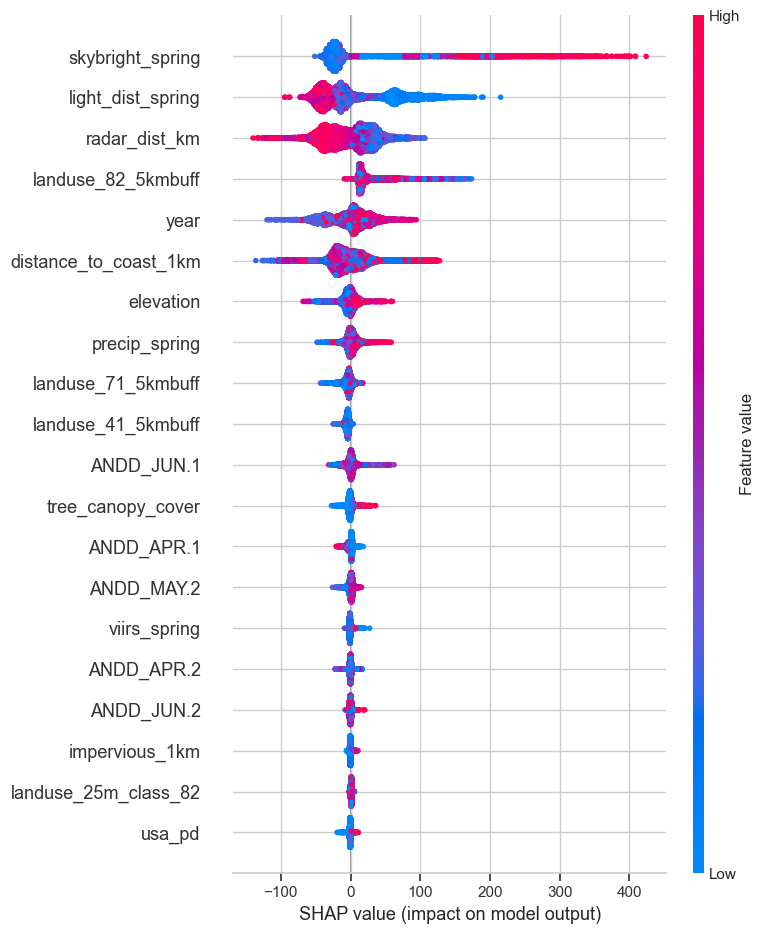

In [72]:
import matplotlib.pyplot as plt
plt.figure()
# 可视化SHAP值
shap.summary_plot(shap_values, holdout_data[columns_to_include],show=False)

# 保存图像
plt.savefig('212_summary.pdf', bbox_inches='tight')

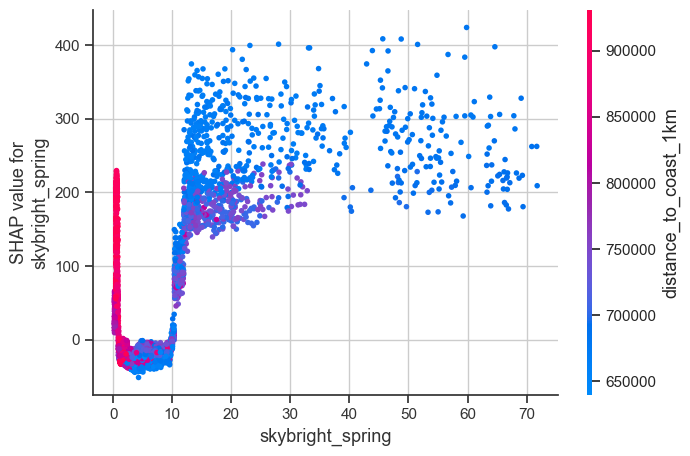

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
# SHAP依赖图
shap.dependence_plot("skybright_spring", shap_values,
                     holdout_data[columns_to_include],show=False)
# 保存图像
plt.savefig('212_dependence_skybright.pdf', bbox_inches='tight')

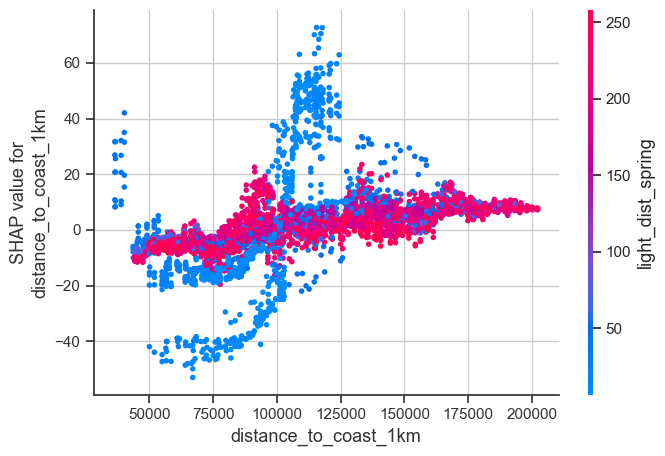

In [70]:

# SHAP依赖图
shap.dependence_plot("distance_to_coast_1km", shap_values,
                     holdout_data[columns_to_include], interaction_index=None, show=False)
# 保存图像
plt.savefig('113_dependence_coast.pdf', bbox_inches='tight')

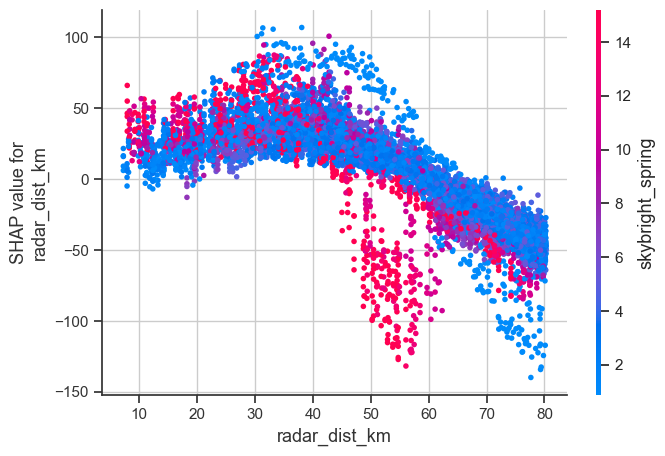

In [27]:
# SHAP依赖图
shap.dependence_plot("radar_dist_km", shap_values,
                     holdout_data[columns_to_include], show=False)
# 保存图像
plt.savefig('212_dependence_radar.pdf', bbox_inches='tight')

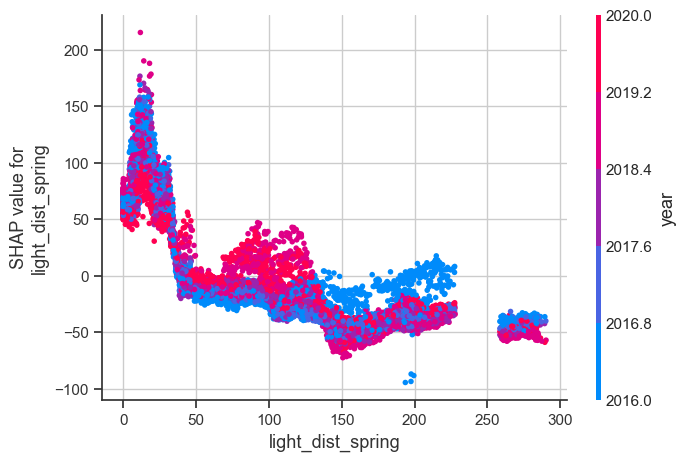

In [28]:
# SHAP依赖图
shap.dependence_plot("light_dist_spring", shap_values,
                     holdout_data[columns_to_include], show=False)
# 保存图像
plt.savefig('212_dependence_lightdist.pdf', bbox_inches='tight')

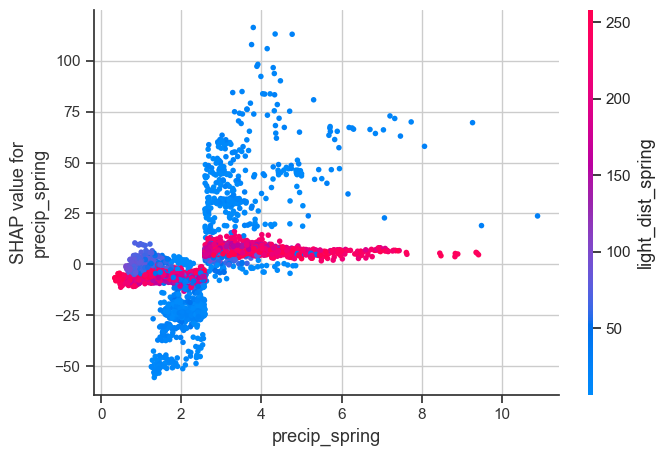

In [69]:
# SHAP依赖图
shap.dependence_plot("precip_spring", shap_values,
                     holdout_data[columns_to_include], interaction_index=None, show=False)
# 保存图像
plt.savefig('113_dependence_precip.pdf', bbox_inches='tight')

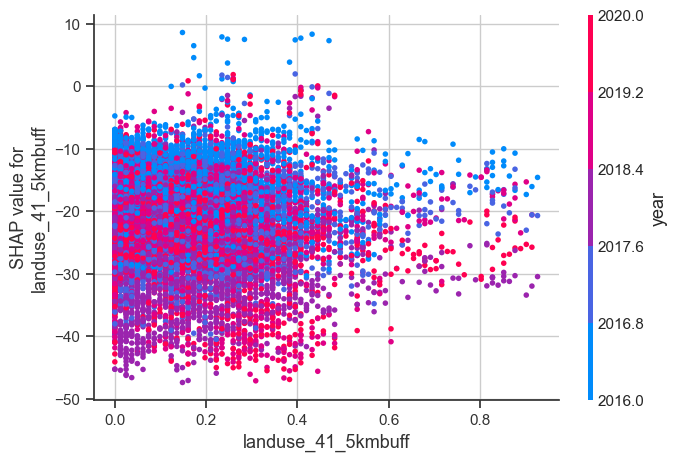

In [60]:
# SHAP依赖图
shap.dependence_plot("landuse_41_5kmbuff", shap_values,
                     holdout_data[columns_to_include], interaction_index=None, show=False)
# 保存图像
plt.savefig('76_dependence_41.pdf', bbox_inches='tight')

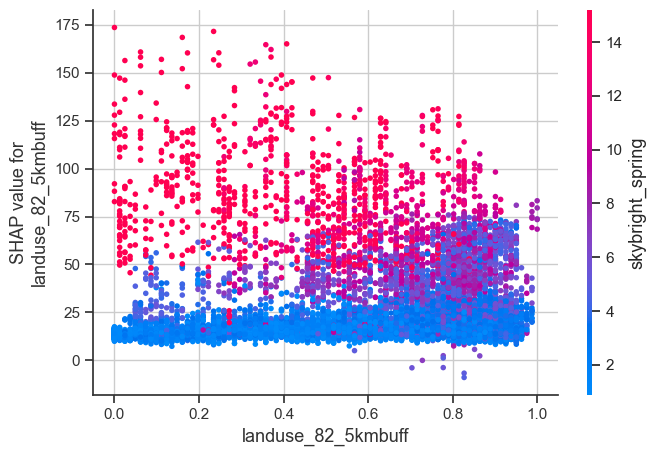

In [29]:
# SHAP依赖图
shap.dependence_plot("landuse_82_5kmbuff", shap_values,
                     holdout_data[columns_to_include],  show=False)
# 保存图像
plt.savefig('212_dependence_82.pdf', bbox_inches='tight')

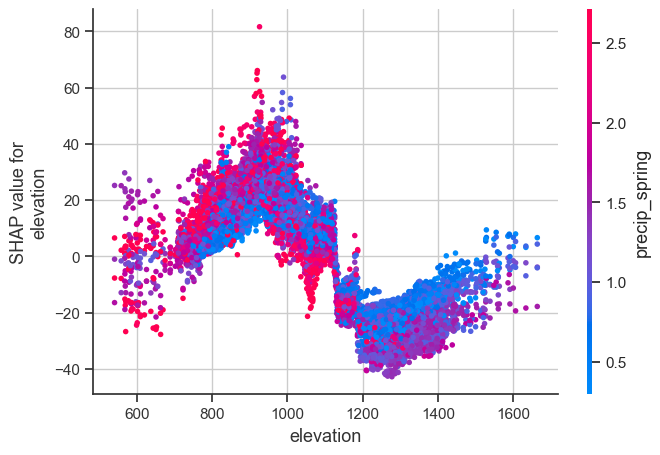

In [48]:
# SHAP依赖图
shap.dependence_plot("elevation", shap_values,
                     holdout_data[columns_to_include], show=False)
# 保存图像
plt.savefig('103_elevation.pdf', bbox_inches='tight')

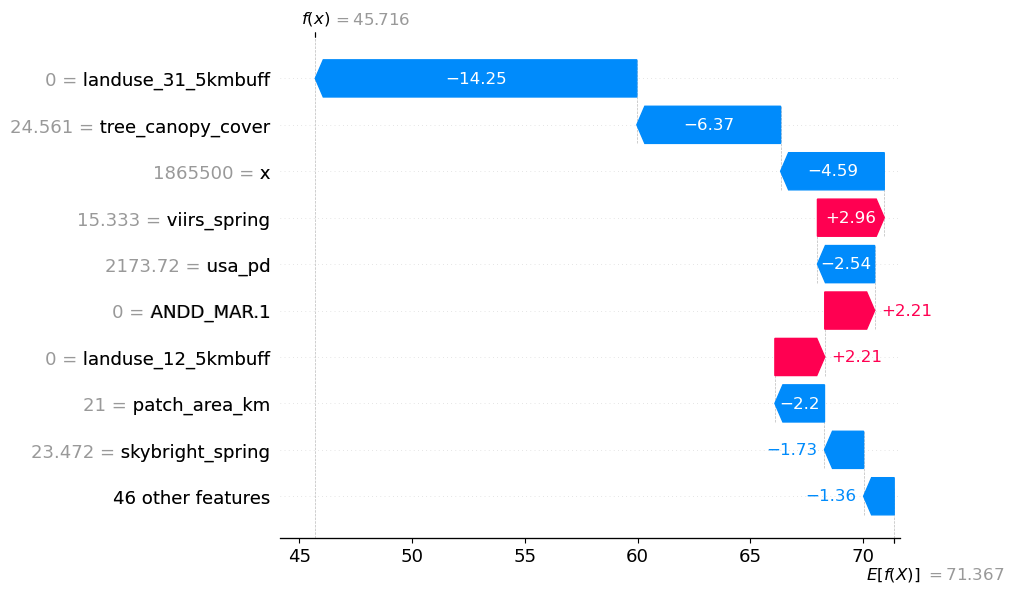

In [24]:

# SHAP瀑布图
shap.waterfall_plot(shap.Explanation(values=shap_values[0, :],
                                     base_values=explainer.expected_value,
                                     data=holdout_data.iloc[0, :]))


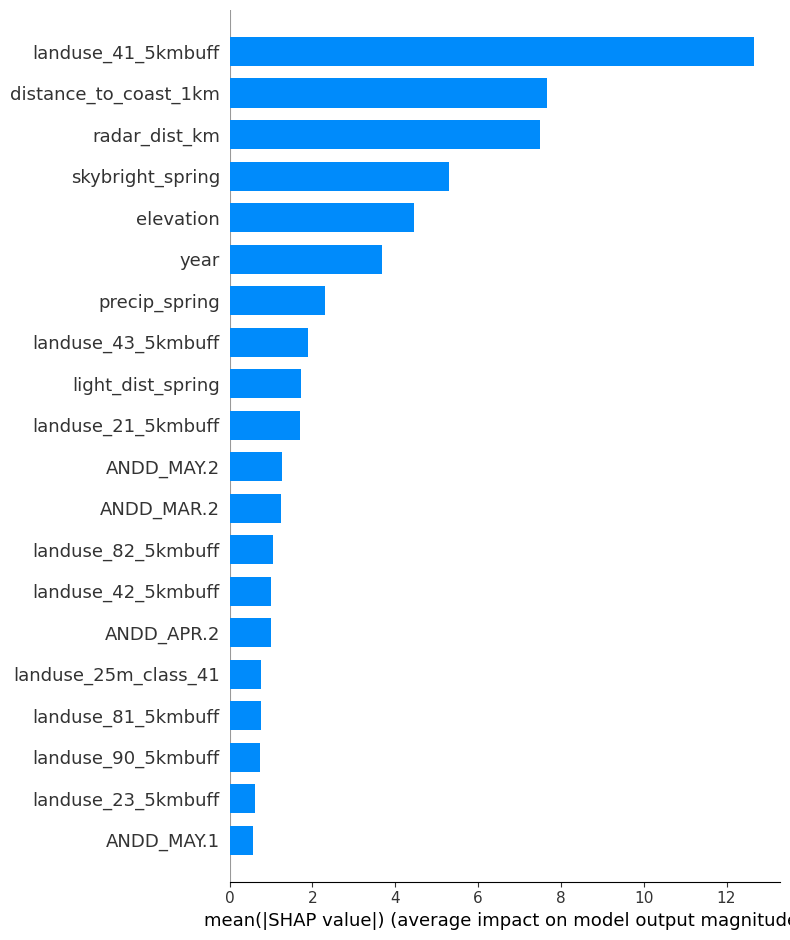

In [26]:

# SHAP条形图
shap.summary_plot(
    shap_values, holdout_data[columns_to_include], plot_type="bar")

## 看一下这些代表模型在哪

可视化生成的样本点...


<Figure size 640x480 with 0 Axes>

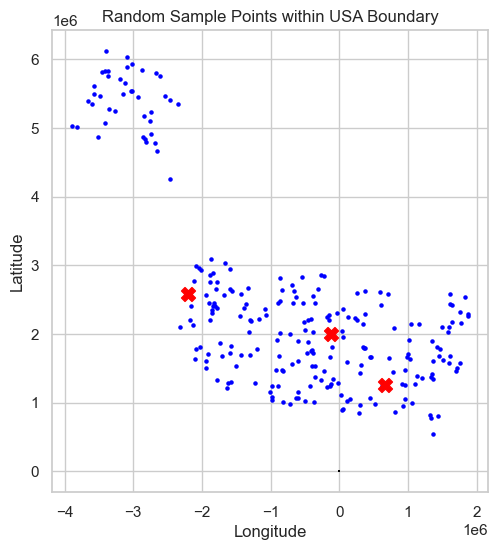

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
# 移除上方和右侧的框线
sns.despine()
usa_gdf = gpd.GeoDataFrame(geometry=[usa.unary_union])

# 可视化生成的样本点
print("可视化生成的样本点...")
bb_samples_gdf = gpd.GeoDataFrame(geometry=bb_samples)
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
base = usa_gdf.plot(ax=ax, color='white', edgecolor='black')
bb_samples_gdf.plot(ax=base, marker='o', color='blue', markersize=5)
# 提取第76个、第113个和第212个采样点（索引分别为75、112和211）
specific_points = bb_samples_gdf.iloc[[75, 112, 211]]
# 标记特定的样本点
specific_points.plot(ax=base, marker='X', color='red',
                     markersize=100, label='Specific Points')

plt.title("Random Sample Points within USA Boundary")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [40]:
# 从GeoJSON文件读取随机样本点
bb_samples_gdf = gpd.read_file("random_sample_points.geojson")
print("已从 random_sample_points.geojson 读取随机样本点")

# 检查样本点数据的当前坐标系
print("样本点数据的当前坐标系:", bb_samples_gdf.crs)
# 如果样本点数据的当前坐标系与目标坐标系不同，进行转换
if bb_samples_gdf.crs != "+proj=aea +lat_0=23 +lon_0=-96 +lat_1=29.5 +lat_2=45.5 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs":
    bb_samples_gdf.set_crs(
        "+proj=aea +lat_0=23 +lon_0=-96 +lat_1=29.5 +lat_2=45.5 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs", allow_override=True)
    print("样本点数据坐标系已直接设置为等面积阿尔伯斯投影")
print(bb_samples_gdf)

已从 random_sample_points.geojson 读取随机样本点
样本点数据的当前坐标系: EPSG:4326
样本点数据坐标系已直接设置为等面积阿尔伯斯投影
                                 geometry
0     POINT (1876727.91778 2259927.70411)
1     POINT (-595263.42546 1069072.43246)
2     POINT (-886815.77964 2446613.79786)
3     POINT (1711861.50947 1507880.25769)
4    POINT (-3193735.42634 5714733.73097)
..                                    ...
245   POINT (-915526.98545 1479021.47984)
246  POINT (-3891434.64685 5029163.38882)
247  POINT (-2684918.09972 4785590.04374)
248  POINT (-2178259.98120 2206529.58470)
249  POINT (-1308847.15885 2022440.92696)

[250 rows x 1 columns]


In [41]:
# 提取第76个、第113个和第212个采样点（索引分别为75、112和211）
bb_samples_gdf = bb_samples_gdf.to_crs("EPSG:4326")
print(bb_samples_gdf)

                                 geometry
0     POINT (1876727.91778 2259927.70411)
1     POINT (-595263.42546 1069072.43246)
2     POINT (-886815.77964 2446613.79786)
3     POINT (1711861.50947 1507880.25769)
4    POINT (-3193735.42634 5714733.73097)
..                                    ...
245   POINT (-915526.98545 1479021.47984)
246  POINT (-3891434.64685 5029163.38882)
247  POINT (-2684918.09972 4785590.04374)
248  POINT (-2178259.98120 2206529.58470)
249  POINT (-1308847.15885 2022440.92696)

[250 rows x 1 columns]


In [39]:
# 输出特定采样点的经纬度坐标
for idx, point in specific_points_wgs84.iterrows():
    print(
        f"Specific Point (Index: {idx}) Location: Longitude = {point.geometry.x}, Latitude = {point.geometry.y}")

Specific Point (Index: 75) Location: Longitude = 660405.133140998, Latitude = 1253390.8623994195
Specific Point (Index: 112) Location: Longitude = -2197826.5969239753, Latitude = 2582348.7927889735
Specific Point (Index: 211) Location: Longitude = -122930.08746339194, Latitude = 2002698.5885886142


In [7]:
from pyproj import Proj, transform

# 定义阿尔伯特投影的投影参数
albers_projection = Proj(proj='aea', lat_1=29.5, lat_2=45.5,
                         lat_0=23, lon_0=-96, x_0=0, y_0=0, datum='WGS84')

# 定义WGS84地理坐标系
wgs84_projection = Proj(proj='latlong', datum='WGS84')

# 示例：阿尔伯特投影中的坐标
albers_x = 660405.133140998  # 替换为你的阿尔伯特投影坐标
albers_y = 1253390.8623994195
x2 = -2197826.5969239753
y2 = 2582348.7927889735
x3 = -122930.08746339194
y3 = 2002698.5885886142

# 转换为经纬度并将负经度转换为东经/西经格式


def convert_and_adjust_longitude(x, y):
    longitude, latitude = transform(albers_projection, wgs84_projection, x, y)
    if longitude < 0:
        longitude += 360
    return longitude, latitude

# 将经纬度转换为东经/西经和北纬/南纬格式


def format_coordinates(longitude, latitude):
    if longitude > 180:
        longitude = 360 - longitude
        lon_direction = 'W'
    else:
        lon_direction = 'E'

    if latitude < 0:
        lat_direction = 'S'
        latitude = abs(latitude)
    else:
        lat_direction = 'N'

    return f"{latitude:.6f}° {lat_direction}, {longitude:.6f}° {lon_direction}"


longitude, latitude = convert_and_adjust_longitude(albers_x, albers_y)
formatted_coords = format_coordinates(longitude, latitude)
print(f"Coordinates: {formatted_coords}")

longitude, latitude = convert_and_adjust_longitude(x2, y2)
formatted_coords = format_coordinates(longitude, latitude)
print(f"Coordinates: {formatted_coords}")

longitude, latitude = convert_and_adjust_longitude(x3, y3)
formatted_coords = format_coordinates(longitude, latitude)
print(f"Coordinates: {formatted_coords}")

Coordinates: 34.119131° N, 88.779750° W
Coordinates: 43.339685° N, 123.625071° W
Coordinates: 41.024599° N, 97.473776° W


/var/folders/0q/bpdt4hbj3hd08tlnntct55kh0000gn/T/ipykernel_51855/2748674564.py:22: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  longitude, latitude = transform(albers_projection, wgs84_projection, x, y)


# 聚类，找到代表性模型

In [24]:
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 读取CSV文件
file_path = 'importance/merged_importance_spring.csv'
data = pd.read_csv(file_path)

# 提取特征值（忽略第一列）
features = data.iloc[:, 1:].values

# 标准化特征值
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)


In [27]:
# 确定聚类数目（肘部法则）
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_standardized)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 11), y=sse, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Determining Optimal Number of Clusters')

# 移除上方和右侧的框线
sns.despine()

# 保存图像
plt.savefig("Elbow.pdf")
plt.close()

/Users/redpanda/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/redpanda/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/redpanda/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/redpanda/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.wa

In [28]:

# 选择聚类数量（这里以3为例）
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(features_standardized)

# 获取聚类标签
labels = kmeans.labels_

# 将聚类结果添加到原始数据中
data['Cluster'] = labels

# 输出结果
print(data)
print(data['Cluster'])

            Feature   year  skybright_spring  ANDD_MAR.1  ANDD_APR.1  \
0        Importance  19232             34759       10039        9135   
1     Importance_10   9161             20796         991        4347   
2    Importance_100   1364              2908         473         534   
3    Importance_101  18254             44345       28326       17650   
4    Importance_102  15141             35434        7239        8456   
..              ...    ...               ...         ...         ...   
204   Importance_94  19305             45215       28395       19067   
205   Importance_96  18359             34738       16671       10799   
206   Importance_97  18233             30764       21093        9393   
207   Importance_98   5461              9730         462        1913   
208   Importance_99   9589             18775        1279        4195   

     ANDD_MAR.2  ANDD_APR.2  ANDD_MAY.1  ANDD_MAY.2  ANDD_JUN.1  ...  \
0          3518       17269       13233       12794       10723

/Users/redpanda/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


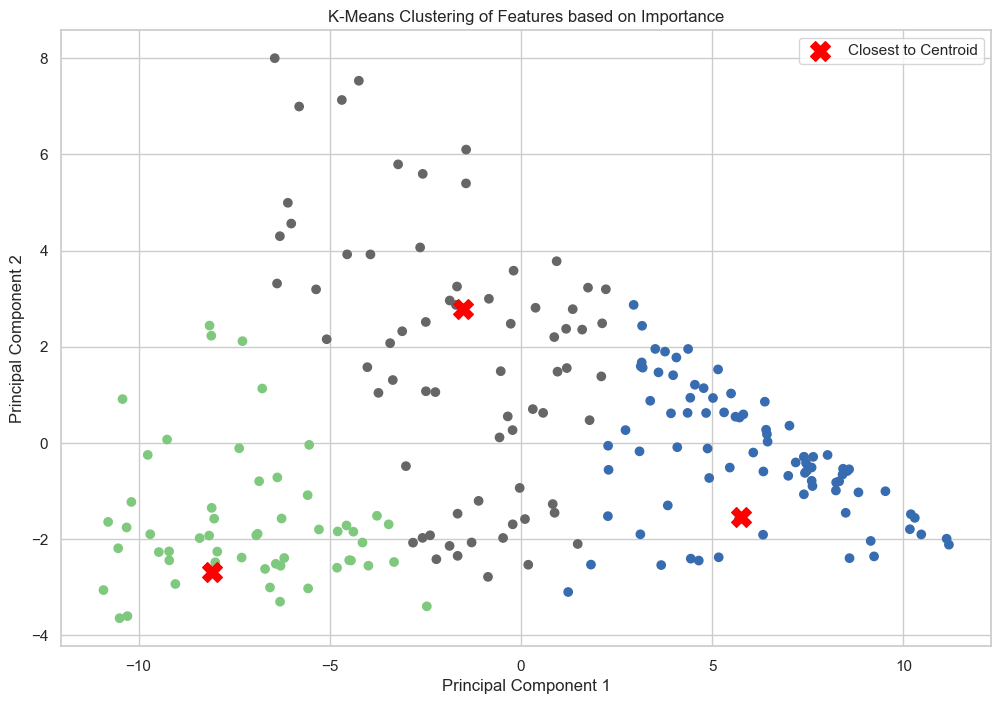

最靠近聚类中心的样本点:
Cluster 0: Feature Importance_76
Cluster 1: Feature Importance_113
Cluster 2: Feature Importance_212


In [65]:
centers = kmeans.cluster_centers_

# 计算每个点到其所属聚类中心的距离
distances = np.linalg.norm(features_standardized - centers[labels], axis=1)

# 找到每个聚类中距离中心最近的样本点
closest_indices = []
for i in range(kmeans.n_clusters):
    cluster_indices = np.where(labels == i)[0]
    closest_index = cluster_indices[np.argmin(distances[cluster_indices])]
    closest_indices.append(closest_index)

# 主成分分析（PCA）降维到2个主成分
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features_standardized)

# 可视化聚类结果
plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    principal_components[:, 0], principal_components[:, 1], c=labels, cmap="Accent")
plt.scatter(principal_components[closest_indices, 0], principal_components[closest_indices, 1],
            c='red', s=200, marker='X', label='Closest to Centroid')  # 标记距离中心最近的点
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering of Features based on Importance')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.legend()
plt.savefig("K-Means.pdf")
plt.show()

# 输出最靠近聚类中心的样本点信息
print("最靠近聚类中心的样本点:")
for i, index in enumerate(closest_indices):
    print(
        f"Cluster {i}: Feature {data.iloc[index]['Feature']}")